In [1]:
import pandas as pd
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

api = wandb.Api()

In [ ]:
runs = api.runs("amar-research/safetyh")
names = ['eval_trained_vs_4scenarios', 'eval_trained_vs_4mobil', 'eval_bestsweep', 'eval_trained_vs_holdout']

summary_list, config_list, name_list = [], [], []
for run in runs:
    if run.name in names:
        print(f"Found {run.name}")
        summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

Found eval_bestsweep
Found eval_trained_vs_4mobil
Found eval_trained_vs_holdout
Found eval_trained_vs_4scenarios
4
4
4


In [10]:
scenarios = ['IdleSlower', 'IdleFaster', 'CutIn', 'CutInSlowDown']
orientations_og = ['forward_center', 'behind_center', 'adjacent_left', 'adjacent_right', 'forward_left', 'forward_right', 'behind_left', 'behind_right']
mobil_prefix = 'MobilPolicy.'

name_labels = {
    'eval_bestsweep': 'trained_vs_4scenarios+4mobil',
    'eval_trained_vs_4mobil': 'trained_vs_4mobil',
    'eval_trained_vs_holdout': 'trained_vs_holdout',
    'eval_trained_vs_4scenarios': "trained_vs_4scenarios"
}

episode_rewards = {}

for run in range(len(runs_df)):
    for scenario in scenarios:
        episode_rewards = runs_df['summary'][run][f'checkpoint_summary/{scenario}/episode_rewards']
        print(f'{runs_df['name'][run]} - {scenario} episode_rewards: {episode_rewards}')

    for mobil in orientations:
        episode_rewards = runs_df['summary'][run][f'checkpoint_summary/{mobil_prefix}{mobil}/episode_rewards']
        print(f'{runs_df['name'][run]} - {mobil} episode_rewards: {episode_rewards}')


eval_bestsweep - IdleSlower episode_rewards: 0.9768843502859598
eval_bestsweep - IdleFaster episode_rewards: 0.9852925999303274
eval_bestsweep - CutIn episode_rewards: 0.9766847668337938
eval_bestsweep - CutInSlowDown episode_rewards: 0.9818103313101024
eval_bestsweep - forward_center episode_rewards: 0.9708207073156327
eval_bestsweep - behind_center episode_rewards: 0.9742252283085728
eval_bestsweep - adjacent_left episode_rewards: 0.9665477631689884
eval_bestsweep - adjacent_right episode_rewards: 0.9786259332636608
eval_trained_vs_4mobil - IdleSlower episode_rewards: 0.5666666666666667
eval_trained_vs_4mobil - IdleFaster episode_rewards: 0.7520159001242402
eval_trained_vs_4mobil - CutIn episode_rewards: 0.7380766277433091
eval_trained_vs_4mobil - CutInSlowDown episode_rewards: 0.7422928894410645
eval_trained_vs_4mobil - forward_center episode_rewards: 0.9688212584827156
eval_trained_vs_4mobil - behind_center episode_rewards: 0.964980089122794
eval_trained_vs_4mobil - adjacent_left e

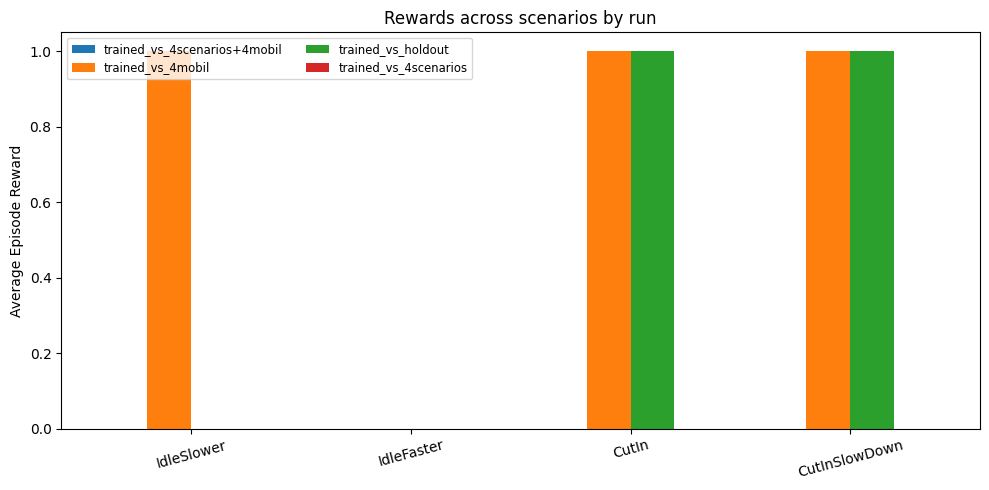

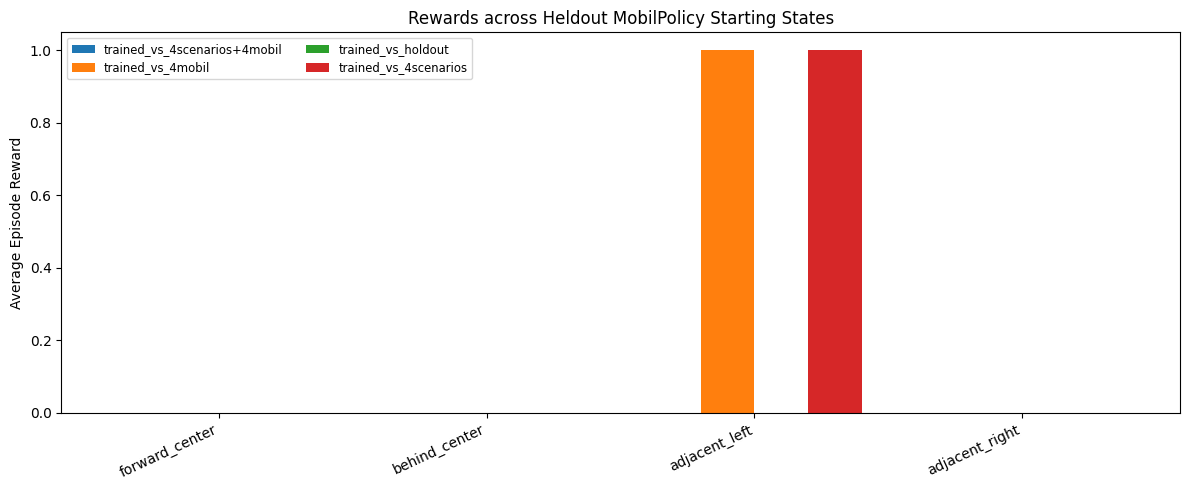

In [ ]:
run_ids = list(runs_df['name'])
n_runs = len(runs_df)
n_scen = len(scenarios)

orientations = ['forward_center', 'behind_center', 'adjacent_left', 'adjacent_right']

n_orients = len(orientations)

name_labels = {
    'eval_bestsweep': 'trained_vs_4scenarios+4mobil',
    'eval_trained_vs_4mobil': 'trained_vs_4mobil',
    'eval_trained_vs_holdout': 'trained_vs_holdout',
    'eval_trained_vs_4scenarios': "trained_vs_4scenarios"
}
# data[label] -> list of means aligned with scenarios
data = {}
data_orients = {}

for run_idx in range(n_runs):
    run_id = runs_df['name'][run_idx]
    label = name_labels.get(run_id, run_id)  # pretty label if available
    per_scen_means = []
    for scenario in scenarios:
        key = f'checkpoint_summary/{scenario}/episode_rewards'
        rewards = None
        # Be defensive: some rows may not have the key or may be None
        summary = runs_df['summary'][run_idx]
        if isinstance(summary, dict):
            rewards = summary.get(key, None)
        # rewards could be a list or a scalar
        if rewards is None:
            per_scen_means.append(np.nan)
        else:
            try:
                # If it's iterable, average it; if scalar, cast to float
                if hasattr(rewards, "__iter__") and not isinstance(rewards, (str, bytes, dict)):
                    per_scen_means.append(float(np.mean(list(rewards))))
                else:
                    per_scen_means.append(float(rewards))
            except Exception:
                per_scen_means.append(np.nan)
    data[label] = per_scen_means
    per_orient_means = []
    for orient in orientations:
        key = f'checkpoint_summary/{mobil_prefix}{orient}/episode_rewards'
        rewards = summary.get(key) if isinstance(summary, dict) else None
        if rewards is None:
            per_orient_means.append(np.nan)
        else:
            try:
                if hasattr(rewards, "__iter__") and not isinstance(rewards, (str, bytes, dict)):
                    per_orient_means.append(float(np.mean(list(rewards))))
                else:
                    per_orient_means.append(float(rewards))
            except Exception:
                per_orient_means.append(np.nan)
    data_orients[label] = per_orient_means

# --- Plot grouped bars ---
x = np.arange(n_scen)
width = 0.8 / max(1, n_runs)  # keep bars within the axis

plt.figure(figsize=(10, 5))
for i, (label, vals) in enumerate(data.items()):
    # Center groups around each scenario tick
    offsets = (i - (n_runs - 1) / 2) * width
    plt.bar(x + offsets, vals, width, label=label)

plt.xticks(x, scenarios, rotation=15)
plt.ylabel('Average Episode Reward')
plt.title('Rewards across scenarios by run')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

x = np.arange(n_orients)
width = 0.8 / max(1, n_runs)
plt.figure(figsize=(12, 5))
for i, (label, vals) in enumerate(data_orients.items()):
    offsets = (i - (n_runs - 1) / 2) * width
    plt.bar(x + offsets, vals, width, label=label)

plt.xticks(x, orientations, rotation=25, ha='right')
plt.ylabel('Average Episode Reward')
plt.title('Rewards across Heldout MobilPolicy Starting States')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

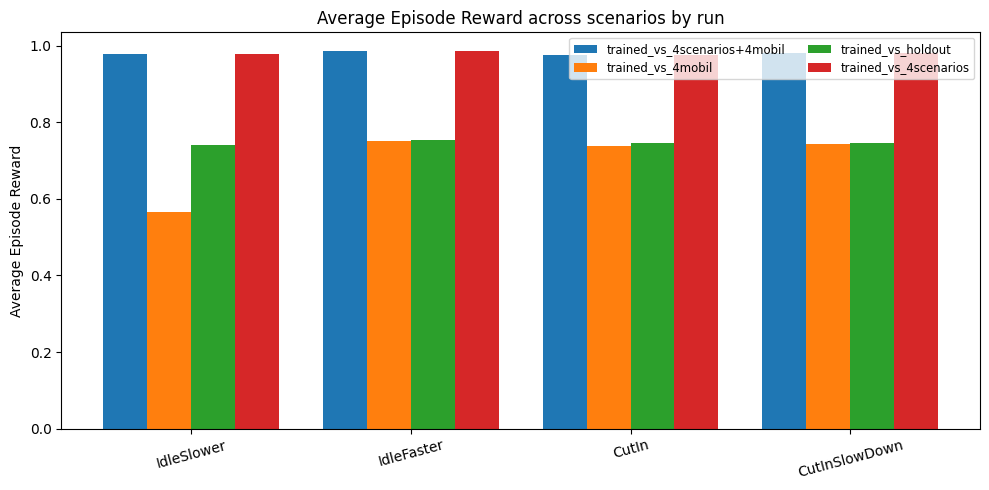

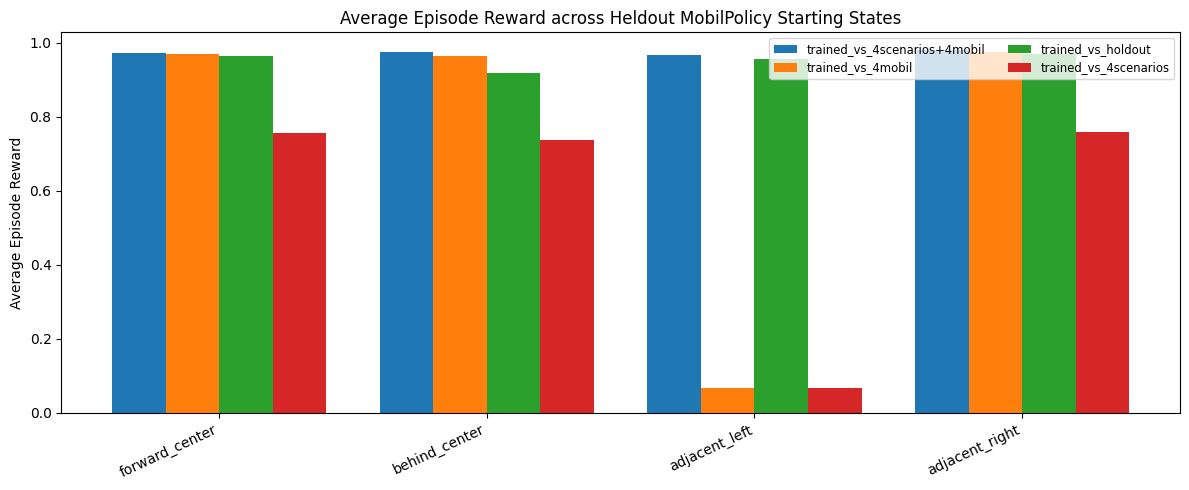

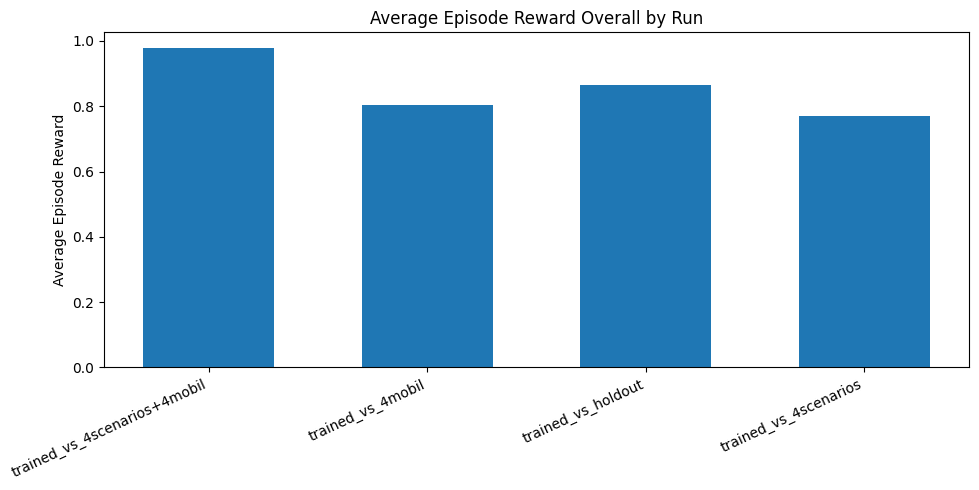

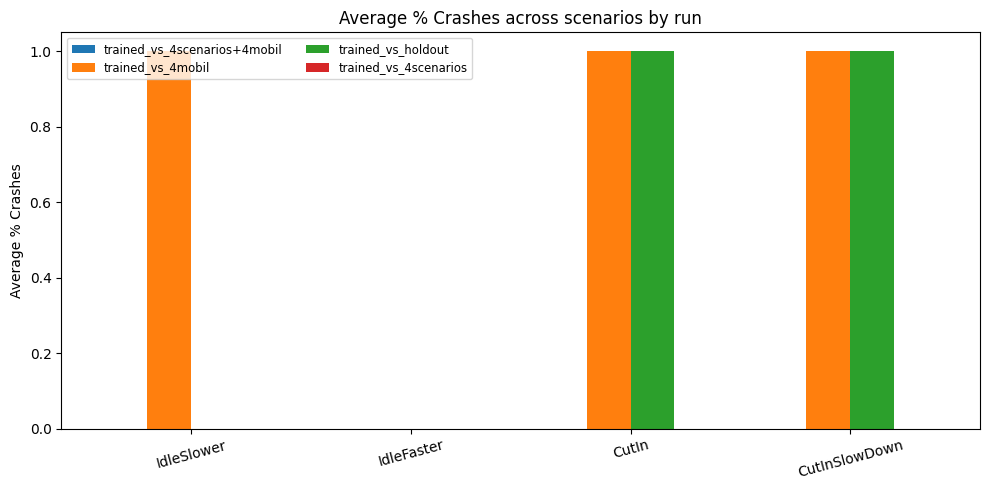

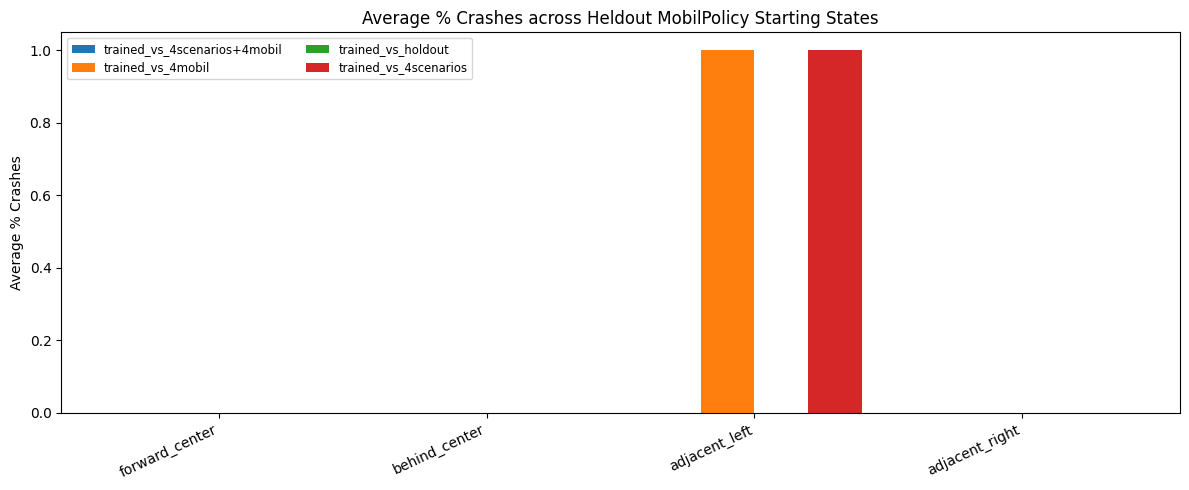

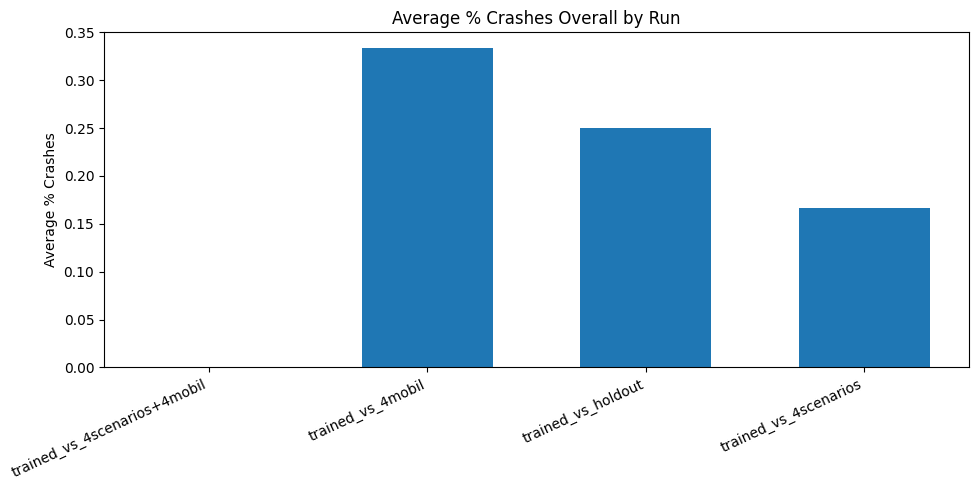

In [17]:
# --- New: choose which metrics to visualize ---
metrics = {
    "episode_rewards": "Average Episode Reward",
    "num_crashes": "Average % Crashes",
}

run_ids = list(runs_df['name'])
n_runs = len(runs_df)
n_scen = len(scenarios)

orientations = ['forward_center', 'behind_center', 'adjacent_left', 'adjacent_right']
n_orients = len(orientations)

name_labels = {
    'eval_bestsweep': 'trained_vs_4scenarios+4mobil',
    'eval_trained_vs_4mobil': 'trained_vs_4mobil',
    'eval_trained_vs_holdout': 'trained_vs_holdout',
    'eval_trained_vs_4scenarios': "trained_vs_4scenarios"
}

def _safe_mean(x):
    """Return float mean if iterable/arraylike; else float(x); else np.nan."""
    import numpy as np
    if x is None:
        return np.nan
    try:
        if hasattr(x, "__iter__") and not isinstance(x, (str, bytes, dict)):
            return float(np.mean(list(x)))
        return float(x)
    except Exception:
        return np.nan

def collect_means_for_metric(metric_key):
    """
    Build three dicts keyed by run label:
      data_scen[label] = list of means aligned with `scenarios`
      data_orients[label] = list of means aligned with `orientations`
      overall[label] = single scalar mean across all (if available)
    """
    import numpy as np
    data_scen, data_orients, overall = {}, {}, {}
    for run_idx in range(n_runs):
        run_id = runs_df['name'][run_idx]
        label = name_labels.get(run_id, run_id)
        summary = runs_df['summary'][run_idx]

        # Scenarios
        per_scen_means = []
        for scenario in scenarios:
            key = f'checkpoint_summary/{scenario}/{metric_key}'
            val = summary.get(key, None) if isinstance(summary, dict) else None
            per_scen_means.append(_safe_mean(val))
        data_scen[label] = per_scen_means

        # Mobil orientations
        per_orient_means = []
        for orient in orientations:
            key = f'checkpoint_summary/{mobil_prefix}{orient}/{metric_key}'
            val = summary.get(key, None) if isinstance(summary, dict) else None
            per_orient_means.append(_safe_mean(val))
        data_orients[label] = per_orient_means

        # Overall
        key = f'checkpoint_summary/{metric_key}'
        val = summary.get(key, None) if isinstance(summary, dict) else None
        overall[label] = _safe_mean(val)

    return data_scen, data_orients, overall


# --- Plot for each metric ---
for metric_key, ylabel in metrics.items():
    data, data_orients, overall = collect_means_for_metric(metric_key)

    # --- Scenarios grouped bars ---
    x = np.arange(n_scen)
    width = 0.8 / max(1, n_runs)

    plt.figure(figsize=(10, 5))
    for i, (label, vals) in enumerate(data.items()):
        offsets = (i - (n_runs - 1) / 2) * width
        plt.bar(x + offsets, vals, width, label=label)

    plt.xticks(x, scenarios, rotation=15)
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} across scenarios by run')
    plt.legend(ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()

    # --- Mobil orientations grouped bars ---
    x = np.arange(n_orients)
    width = 0.8 / max(1, n_runs)

    plt.figure(figsize=(12, 5))
    for i, (label, vals) in enumerate(data_orients.items()):
        offsets = (i - (n_runs - 1) / 2) * width
        plt.bar(x + offsets, vals, width, label=label)

    plt.xticks(x, orientations, rotation=25, ha='right')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} across Heldout MobilPolicy Starting States')
    plt.legend(ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()

    # --- Overall (one bar per run) ---
    labels = list(overall.keys())
    values = list(overall.values())
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 5))
    plt.bar(x, values, width=0.6)
    plt.xticks(x, labels, rotation=25, ha='right')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} Overall by Run')
    plt.tight_layout()
    plt.show()